In [1]:

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np

params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    # 'font.family': TODO add font family
    # 'text.usetex': True
}

mpl.rcParams.update(params)

import sys
# Local Modules
sys.path.insert(0, '../')

## Load the time series data and see some basic statistics

In [2]:
df_timeseries = pd.read_csv("./../data/df_timeseries_en.tsv", sep="\t", compression='infer', usecols=['datetime', 'channel', 'views', 'subs'])
df_timeseries['datetime'] = pd.to_datetime(df_timeseries['datetime'])

# TODO partial preprocessing : all dates do not match, need to set them to the start of each week
# Add 1 hour to the datetime to make 23:00:00 -> 00:00:00 so that the days all match
df_timeseries['datetime'] = df_timeseries['datetime'] + pd.DateOffset(hours=1)
# Set the time to 00:00:00 for all the dates
df_timeseries['datetime'] = df_timeseries['datetime'].dt.floor('d')

print("there are", df_timeseries['channel'].nunique(), "unique channels among the", df_timeseries.shape[0], "entries")
print("from", df_timeseries['datetime'].min(), "to", df_timeseries['datetime'].max(), ":", df_timeseries['datetime'].nunique(), "unique timestamps")

df_timeseries

there are 133516 unique channels among the 18872499 entries
from 2015-01-05 00:00:00 to 2019-09-30 00:00:00 : 248 unique timestamps


,channel,datetime,views,subs
0,UCBJuEqXfXTdcPSbGO9qqn1g,2017-07-03,2.024946e+05,650.222222
1,UCBJuEqXfXTdcPSbGO9qqn1g,2017-07-10,3.940857e+05,1046.000000
2,UCBJuEqXfXTdcPSbGO9qqn1g,2017-07-17,8.353938e+05,1501.500000
3,UCBJuEqXfXTdcPSbGO9qqn1g,2017-07-24,1.104577e+06,1750.000000
4,UCBJuEqXfXTdcPSbGO9qqn1g,2017-07-31,1.284406e+06,2008.300000
...,...,...,...,...
18872494,UC0UeVA9YHpOEr_Ng442xiRw,2019-09-02,6.012938e+06,61268.611111
18872495,UC0UeVA9YHpOEr_Ng442xiRw,2019-09-09,6.244579e+06,62631.666667
18872496,UC0UeVA9YHpOEr_Ng442xiRw,2019-09-16,6.480902e+06,64010.000000
18872497,UC0UeVA9YHpOEr_Ng442xiRw,2019-09-23,6.745317e+06,65480.000000


## Find channels that saw their subscribers decrease by more than 10% in one week

In [3]:
#from src.utils import find_bad_buzzes
def find_bad_buzzes(df, min_subs_decrease, min_views_increase):
    # Sort by channel and datetime to ensure chronological order
    df = df.sort_values(by=['channel', 'datetime']).reset_index(drop=True)
    
    # Calculate the percentage change in subscribers for each channel over time
    df['subs_pct_change'] = df.groupby('channel')['subs'].pct_change()
    df['views_pct_change'] = df.groupby('channel')['views'].pct_change()

    # Filter rows where the percentage change is below the threshold
    bad_buzzes = df[(df['subs_pct_change'] < -min_subs_decrease) & (df['subs_pct_change'].notna()) & (df['views_pct_change'] > min_views_increase) & (df['views_pct_change'].notna())]
    
    # Select relevant columns and group by channel
    result = bad_buzzes[['channel', 'datetime', 'subs_pct_change','views_pct_change']].groupby('channel').agg(list)
    
    return result

BAD_BUZZ_SUBS_THRESHOLD = 0.1
BAD_BUZZ_VIEWS_THRESHOLD = 0.05
BAD_BUZZ_LIKES_THRESHOLD = 0.5
BAD_BUZZ_DISLIKES_THRESHOLD = 0.5


bad_buzz_channels = find_bad_buzzes(df_timeseries, BAD_BUZZ_SUBS_THRESHOLD, BAD_BUZZ_VIEWS_THRESHOLD)

print("there are", bad_buzz_channels.shape[0], f"channels with bad buzzes, with threshold {BAD_BUZZ_SUBS_THRESHOLD} for subs and {BAD_BUZZ_VIEWS_THRESHOLD} for views")

bad_buzz_channels


there are 313 channels with bad buzzes, with threshold 0.1 for subs and 0.05 for views


,datetime,subs_pct_change,views_pct_change
channel,,,
UC-KdughvLV6oHGKiNE31fQw,[2016-10-03 00:00:00],[-0.5018108223263741],[0.4565931487564523]
UC-SDYxPtq8BL8vOI9HG7_5A,[2017-06-12 00:00:00],[-0.2085808580858085],[0.2981034503493645]
UC0-r1kNEhgXwB1vQze3r3fA,[2018-12-17 00:00:00],[-0.13295774647887326],[0.08499068901303541]
UC0LVj2FAfHF_HyVRlXPU8Qg,"[2017-12-18 00:00:00, 2017-12-25 00:00:00]","[-0.17985948477751756, -0.21930325528269556]","[1.8276708944253937, 0.2950817604680258]"
UC0O8MdK4sGVKM_grPX_Bmjw,[2016-07-04 00:00:00],[-0.10660707814953496],[0.08909347002989998]
...,...,...,...
UCyR0mm2YWL0GE4gmTb761xw,"[2018-12-17 00:00:00, 2018-12-24 00:00:00]","[-0.23462491815545783, -0.17966422755533829]","[0.05788789041166198, 0.05237210637344636]"
UCykYcRUh5GbfUYRtGUjBLcA,[2016-08-22 00:00:00],[-0.14383561643835618],[0.79441023211748]
UCzBPtNZ8Wxz4kRhIeOvjqSQ,[2018-01-15 00:00:00],[-0.46501297664204444],[0.14805923566139878]


## Include the likes & dislikes per week (only for those that appear on the list above)

In [29]:
df_videos_likes = pd.read_feather("./../data/yt_metadata_helper.feather", columns=['channel_id', 'upload_date', 'like_count', 'dislike_count'])
df_videos_likes['upload_date'] = pd.to_datetime(df_videos_likes['upload_date'])
df_videos_likes = df_videos_likes[df_videos_likes['channel_id'].isin(bad_buzz_channels.index)]

df_videos_likes

,channel_id,upload_date,like_count,dislike_count
402502,UCzBPtNZ8Wxz4kRhIeOvjqSQ,2019-10-02,46.0,2.0
402503,UCzBPtNZ8Wxz4kRhIeOvjqSQ,2019-10-02,82.0,2.0
402504,UCzBPtNZ8Wxz4kRhIeOvjqSQ,2019-10-02,64.0,3.0
402505,UCzBPtNZ8Wxz4kRhIeOvjqSQ,2019-10-01,45.0,2.0
402506,UCzBPtNZ8Wxz4kRhIeOvjqSQ,2019-10-01,56.0,2.0
...,...,...,...,...
72882125,UCrxw-rZniGlUrVJ_T9J0DCg,2017-04-29,33.0,1.0
72882126,UCrxw-rZniGlUrVJ_T9J0DCg,2017-04-28,20.0,5.0
72882127,UCrxw-rZniGlUrVJ_T9J0DCg,2017-04-27,14.0,0.0
72882128,UCrxw-rZniGlUrVJ_T9J0DCg,2017-04-26,24.0,0.0


In [5]:
def find_likes_bad_buzzes(df, min_likes_decrease, min_dislikes_increase):
    # Sort by channel and datetime to ensure chronological order
    df = df.sort_values(by=['channel_id', 'upload_date']).reset_index(drop=True)
    
    # Calculate the percentage change in subscribers for each channel over time
    df['likes_pct_change'] = df.groupby('channel_id')['like_count'].pct_change(fill_method=None)
    df['dislikes_pct_change'] = df.groupby('channel_id')['dislike_count'].pct_change(fill_method=None)

    # Filter rows where the percentage change is below the threshold
    bad_buzzes = df[(df['likes_pct_change'] < -min_likes_decrease) & (df['likes_pct_change'].notna()) & (df['dislikes_pct_change'] > min_dislikes_increase) & (df['dislikes_pct_change'].notna())]
    
    # Select relevant columns and group by channel
    result = bad_buzzes[['channel_id', 'upload_date', 'likes_pct_change','dislikes_pct_change']].groupby('channel_id').agg(list)
    
    return result

likes_bad_buzz_channels = find_likes_bad_buzzes(df_videos_likes, BAD_BUZZ_LIKES_THRESHOLD, BAD_BUZZ_DISLIKES_THRESHOLD)

print("there are", likes_bad_buzz_channels.shape[0], f"channels with likes bad buzzes, with threshold {BAD_BUZZ_LIKES_THRESHOLD} for likes and {BAD_BUZZ_DISLIKES_THRESHOLD} for dislikes")

likes_bad_buzz_channels

there are 220 channels with likes bad buzzes, with threshold 0.5 for likes and 0.5 for dislikes


,upload_date,likes_pct_change,dislikes_pct_change
channel_id,,,
UC-KdughvLV6oHGKiNE31fQw,[2019-04-30 00:00:00],[-0.7959183673469388],[0.8235294117647058]
UC-SDYxPtq8BL8vOI9HG7_5A,"[2017-07-12 00:00:00, 2019-04-20 00:00:00, 201...","[-0.625, -0.5909090909090908, -0.6875]","[inf, 0.8, 1.0]"
UC0O8MdK4sGVKM_grPX_Bmjw,"[2018-11-25 00:00:00, 2018-11-29 00:00:00, 201...","[-0.5882352941176471, -0.6666666666666667, -0....","[2.5, 4.0, 2.5, 1.0, 5.0, inf, inf]"
UC0OiT6LftC0WwDi1xrP0kQQ,"[2017-09-20 00:00:00, 2017-10-22 00:00:00, 201...","[-0.8333333333333334, -0.8333333333333334, -0....","[inf, inf, 0.7857142857142858]"
UC0P4_2nrwEMw2A1TCsfQYdg,"[2018-03-12 00:00:00, 2018-05-18 00:00:00, 201...","[-0.5873015873015873, -0.5142857142857142, -0....","[3.0, 0.6000000000000001, 0.7777777777777777]"
...,...,...,...
UCyFj5evGK-JkkfdAh5SwCRA,"[2018-01-26 00:00:00, 2019-09-04 00:00:00]","[-0.5401785714285714, -0.5607476635514019]","[1.0, 1.0]"
UCyR0mm2YWL0GE4gmTb761xw,"[2019-03-10 00:00:00, 2019-05-26 00:00:00, 201...","[-0.5368878524485903, -0.6944444444444444, -0....","[2.0458715596330275, inf, inf, inf]"
UCykYcRUh5GbfUYRtGUjBLcA,"[2018-10-08 00:00:00, 2018-12-07 00:00:00, 201...","[-0.7333333333333334, -0.6736842105263158, -0....","[inf, 1.0, 1.0]"


## Find channels that appear in both subs/views bad buzzes and likes/dislikes bad buzzes

In [6]:
print("there are", bad_buzz_channels.shape[0], "channels with bad buzzes, with threshold", BAD_BUZZ_SUBS_THRESHOLD, "for subs and", BAD_BUZZ_VIEWS_THRESHOLD, "for views")
print("there are", likes_bad_buzz_channels.shape[0], "channels with likes bad buzzes, with threshold", BAD_BUZZ_LIKES_THRESHOLD, "for likes and", BAD_BUZZ_DISLIKES_THRESHOLD, "for dislikes")

# Merge the two dataframes
bad_buzz_inner_join = likes_bad_buzz_channels.reset_index().join(bad_buzz_channels.reset_index(), how='inner')

print(f"after join, there are {bad_buzz_inner_join.shape[0]} channels with both bad buzzes")

bad_buzz_inner_join

there are 313 channels with bad buzzes, with threshold 0.1 for subs and 0.05 for views
there are 220 channels with likes bad buzzes, with threshold 0.5 for likes and 0.5 for dislikes
after join, there are 220 channels with both bad buzzes


,channel_id,upload_date,likes_pct_change,dislikes_pct_change,channel,datetime,subs_pct_change,views_pct_change
0,UC-KdughvLV6oHGKiNE31fQw,[2019-04-30 00:00:00],[-0.7959183673469388],[0.8235294117647058],UC-KdughvLV6oHGKiNE31fQw,[2016-10-03 00:00:00],[-0.5018108223263741],[0.4565931487564523]
1,UC-SDYxPtq8BL8vOI9HG7_5A,"[2017-07-12 00:00:00, 2019-04-20 00:00:00, 201...","[-0.625, -0.5909090909090908, -0.6875]","[inf, 0.8, 1.0]",UC-SDYxPtq8BL8vOI9HG7_5A,[2017-06-12 00:00:00],[-0.2085808580858085],[0.2981034503493645]
2,UC0O8MdK4sGVKM_grPX_Bmjw,"[2018-11-25 00:00:00, 2018-11-29 00:00:00, 201...","[-0.5882352941176471, -0.6666666666666667, -0....","[2.5, 4.0, 2.5, 1.0, 5.0, inf, inf]",UC0-r1kNEhgXwB1vQze3r3fA,[2018-12-17 00:00:00],[-0.13295774647887326],[0.08499068901303541]
3,UC0OiT6LftC0WwDi1xrP0kQQ,"[2017-09-20 00:00:00, 2017-10-22 00:00:00, 201...","[-0.8333333333333334, -0.8333333333333334, -0....","[inf, inf, 0.7857142857142858]",UC0LVj2FAfHF_HyVRlXPU8Qg,"[2017-12-18 00:00:00, 2017-12-25 00:00:00]","[-0.17985948477751756, -0.21930325528269556]","[1.8276708944253937, 0.2950817604680258]"
4,UC0P4_2nrwEMw2A1TCsfQYdg,"[2018-03-12 00:00:00, 2018-05-18 00:00:00, 201...","[-0.5873015873015873, -0.5142857142857142, -0....","[3.0, 0.6000000000000001, 0.7777777777777777]",UC0O8MdK4sGVKM_grPX_Bmjw,[2016-07-04 00:00:00],[-0.10660707814953496],[0.08909347002989998]
...,...,...,...,...,...,...,...,...
215,UCyFj5evGK-JkkfdAh5SwCRA,"[2018-01-26 00:00:00, 2019-09-04 00:00:00]","[-0.5401785714285714, -0.5607476635514019]","[1.0, 1.0]",UCiVJGGp2jyxqi5dm8tvYM9g,"[2016-06-27 00:00:00, 2016-07-04 00:00:00]","[-0.12565523438670056, -0.6956149366221309]","[0.09454954412178185, 0.09700561447286349]"
216,UCyR0mm2YWL0GE4gmTb761xw,"[2019-03-10 00:00:00, 2019-05-26 00:00:00, 201...","[-0.5368878524485903, -0.6944444444444444, -0....","[2.0458715596330275, inf, inf, inf]",UCigPztlAIdjHiDbHyN5e9Gw,[2017-12-25 00:00:00],[-0.23098995695839286],[0.7272727272727273]
217,UCykYcRUh5GbfUYRtGUjBLcA,"[2018-10-08 00:00:00, 2018-12-07 00:00:00, 201...","[-0.7333333333333334, -0.6736842105263158, -0....","[inf, 1.0, 1.0]",UCizxEDtKPxWfYG6GH9kaJdA,"[2017-03-13 00:00:00, 2017-03-20 00:00:00]","[-0.14152520576131689, -0.28095273762264994]","[1.3494064720382015, 1.7117161220172443]"
218,UCzBPtNZ8Wxz4kRhIeOvjqSQ,"[2017-05-04 00:00:00, 2017-05-14 00:00:00, 201...","[-0.8205128205128205, -0.5555555555555556, -0....","[1.0, inf, 2.0, inf, 7.0, 1.5, inf, inf, inf, ...",UCj3eNFsbvVpafrt5AbRT2Vg,"[2016-05-09 00:00:00, 2016-06-27 00:00:00, 201...","[-0.12790697674418605, -0.27293844367015097, -...","[0.13502935420743634, 1.1699526211218094, 0.17..."


## Plot the evolution of views and subs for the channels that have had bad buzzes

In [9]:
df_timeseries[df_timeseries['channel'].isin(bad_buzz_inner_join['channel_id'])]

,channel,datetime,views,subs
144030,UCJEDzKwjb-i_SCv6NzFs3Xw,2016-05-16,31102.750000,2243.500000
144031,UCJEDzKwjb-i_SCv6NzFs3Xw,2016-05-23,29795.750000,2674.625000
144032,UCJEDzKwjb-i_SCv6NzFs3Xw,2016-05-30,29915.500000,3238.500000
144033,UCJEDzKwjb-i_SCv6NzFs3Xw,2016-06-06,34668.000000,3661.000000
144034,UCJEDzKwjb-i_SCv6NzFs3Xw,2016-06-13,40273.000000,3672.250000
...,...,...,...,...
18842962,UCTdVJEhnpADQPMrIiBuhtWA,2019-09-02,808657.500000,36888.000000
18842963,UCTdVJEhnpADQPMrIiBuhtWA,2019-09-09,808675.777778,36819.555556
18842964,UCTdVJEhnpADQPMrIiBuhtWA,2019-09-16,808706.000000,36800.000000
18842965,UCTdVJEhnpADQPMrIiBuhtWA,2019-09-23,808741.000000,36800.000000


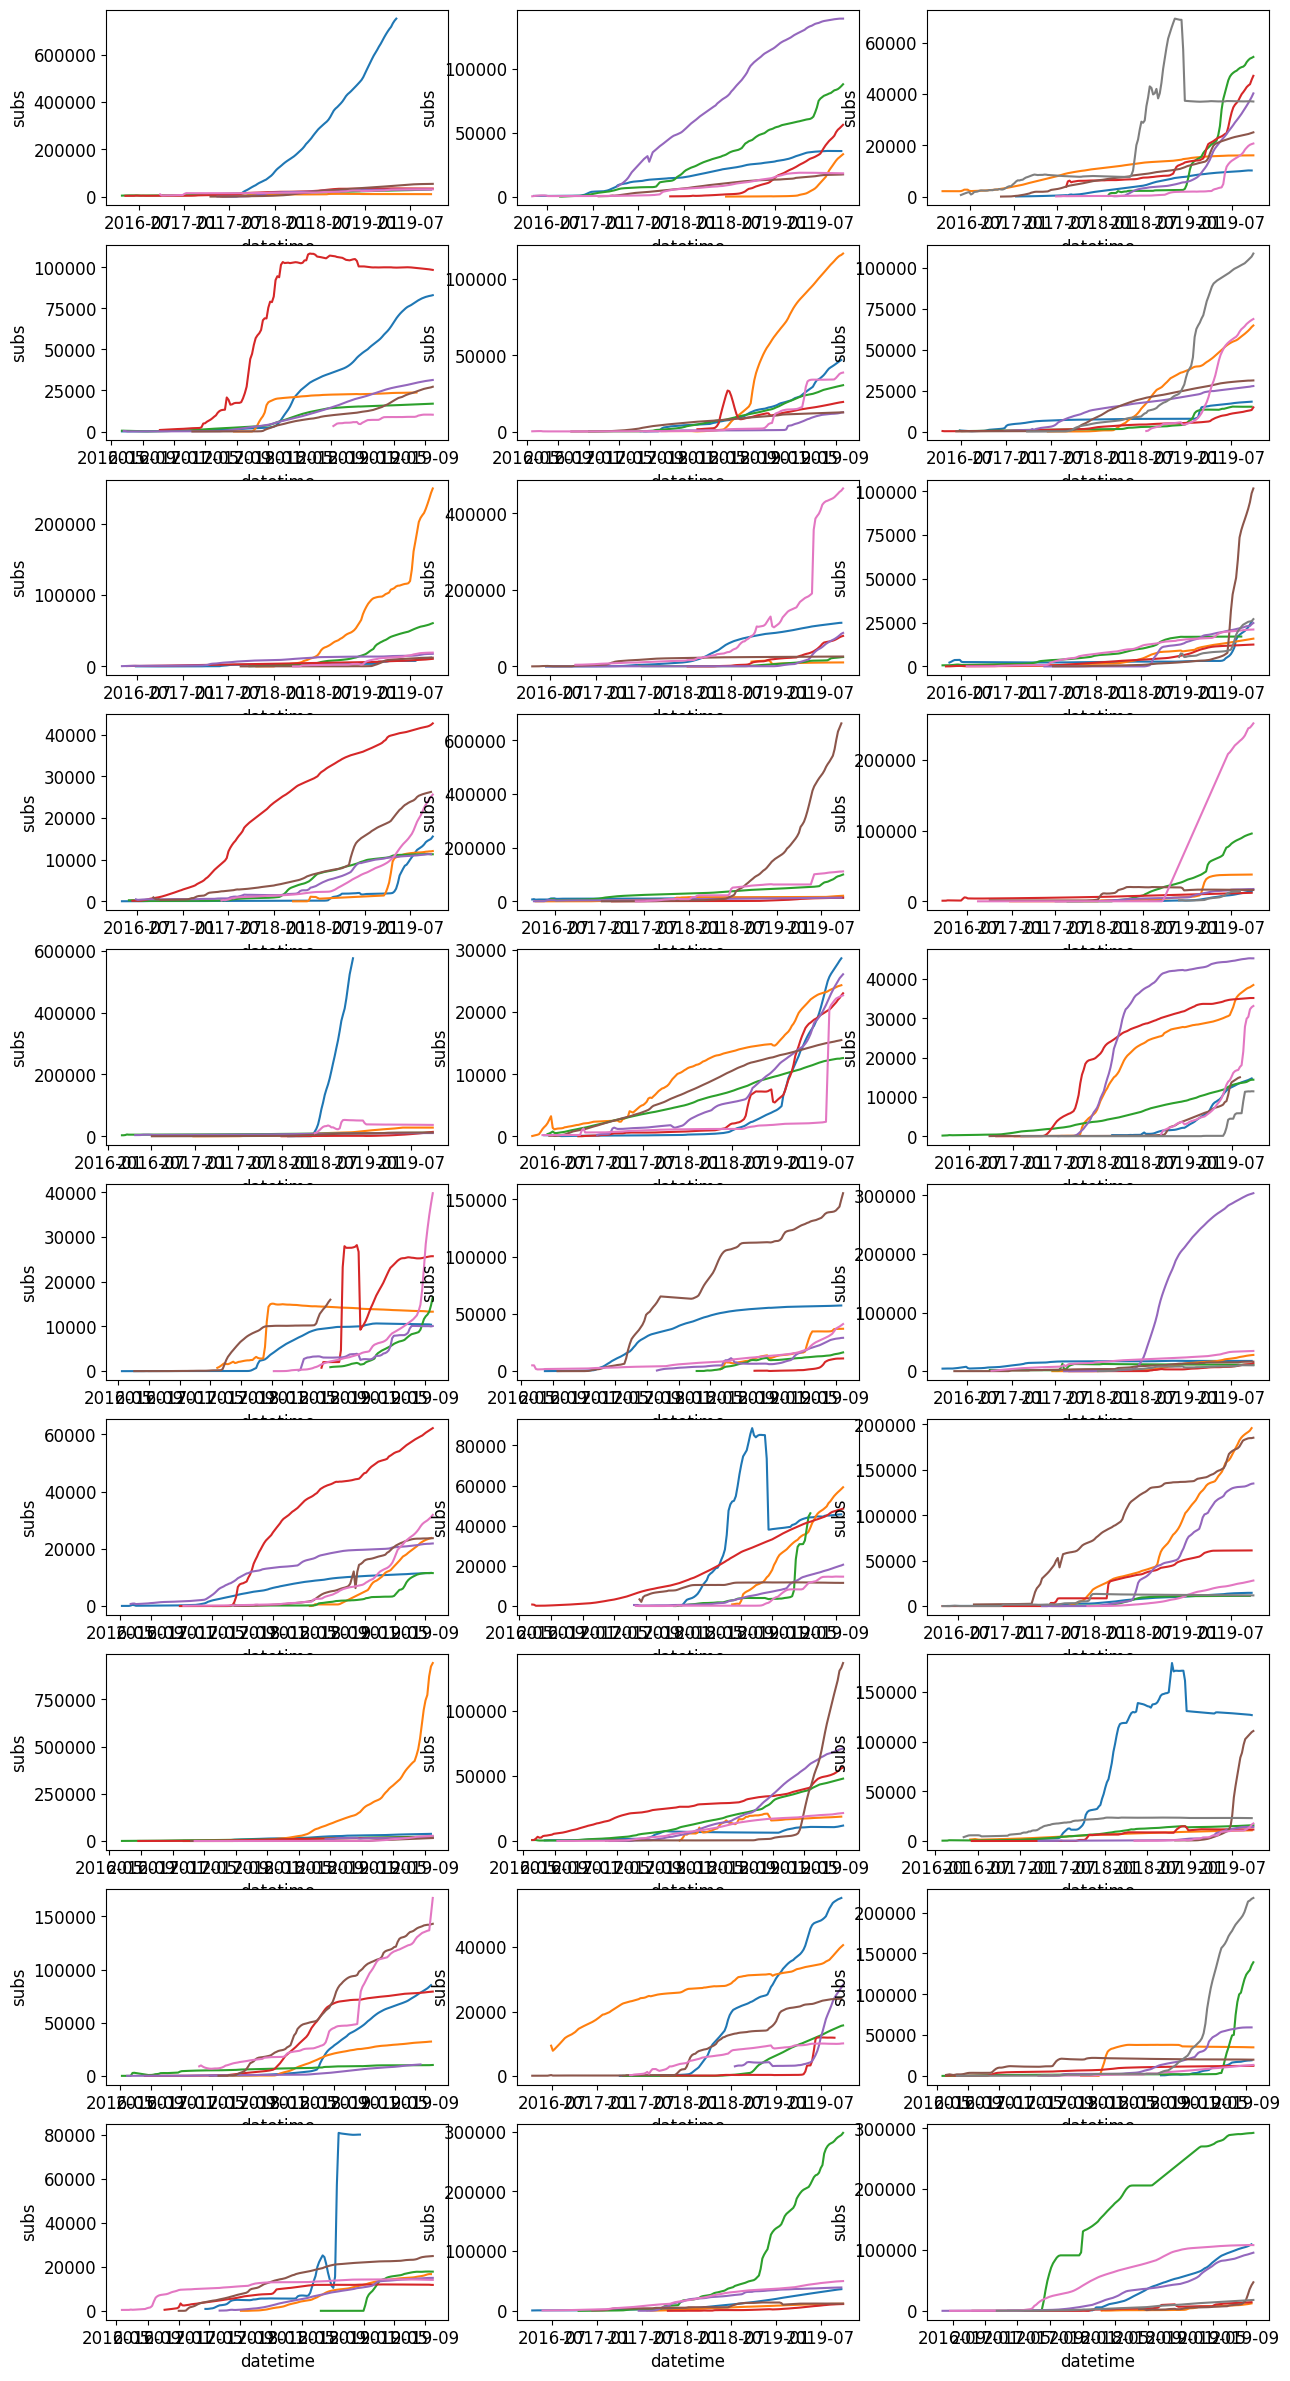

In [28]:
plt.figure(figsize=(15, 30))
channels = bad_buzz_inner_join['channel_id']
size = len(channels)

for i in range(30):
    ax = plt.subplot(10, 3, i+1)
    data = df_timeseries[df_timeseries['channel'].isin(channels[i*size//30:(i+1)*size//30])]
    sns.lineplot(data=data, x='datetime', y='subs', hue='channel', legend=False, ax=ax)

In [ ]:
plt.figure(figsize=(15, 30))
channels = bad_buzz_inner_join['channel_id']
size = len(channels)

for i in range(30):
    ax = plt.subplot(10, 3, i+1)
    data = df_timeseries[df_timeseries['channel'].isin(channels[i*size//30:(i+1)*size//30])]
    sns.lineplot(data=data, x='datetime', y='subs', hue='channel', legend=False, ax=ax)